In [1]:

#calculate maxima of any function?Can this be used
#make terrain of x and y. eliminate range

In [2]:
#Import 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from terrain import *
from functions import *


In [3]:
#Class definition
class Climber():
    
    def __init__(self,position_index,terrain,n_input = 30,step = 15):
        self.n_input = n_input
        self.n_hidden = 10
        self.n_output = 1
        self.learning_rate = 0.5
        
        
        #Outside world
        self.terrain = terrain
        self.position_index = position_index
        
        #step size
        self.step = step
        
        
        # inputs and expected outputs
        self.old_input = self.terrain[0,self.position_index:self.position_index + self.n_input].reshape(self.n_input,1)
        self.input = self.terrain[0,self.position_index:self.position_index + self.n_input].reshape(self.n_input,1)
        self.output = None #Shape 1,1
        self.y = None
        
        #Weights
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        
        self.costs = []
        self.mistakes = 0
        self.position_switch_counter = 0

    def initialize_weights(self):
        self.W1 = np.random.normal(0,1/np.sqrt(self.n_input),size=[self.n_hidden,self.n_input])#Shape 5,10
        self.W2 = np.random.normal(0,1/np.sqrt(self.n_hidden),size=[self.n_output,self.n_hidden])#Shape 1,5
        self.b1 = np.zeros((self.n_hidden,1))#Shape 5,1
        self.b2 = np.zeros((self.n_output,1))#shape 1,1
        
    def feed_forward(self):
        standardized_input =self.standardize(self.input)# self.input.copy()# BOOM!!!!
        z1 = np.dot(self.W1,standardized_input)+self.b1  #Shape 5,1
        a1 = sigmoid(z1)  #Shape 5,1
        z2 = np.dot(self.W2,a1)+self.b2  #Shape 1,1
        a2 = sigmoid(z2)   #Shape 1,1
        self.output = a2.copy()
        
        
        values = {"standardized_input":standardized_input.copy(),"z1":z1,"a1":a1,"z2":z2,"a2":a2}
        return values
    
    def move(self):
        X = None
        if self.output.reshape(1,) > 0.5:
            if self.position_index < self.terrain.shape[1] - (self.n_input+self.step):
                #Move Right
                self.position_index = self.position_index + self.step
                X = self.terrain[0,self.position_index:self.position_index + self.n_input]
                
            else :
                reset_climber(self)
            
        else :
            if self.position_index<self.step:
                reset_climber(self)
                
            else :
                #Move Left
                self.position_index = self.position_index - self.step
                X = self.terrain[0,self.position_index:self.position_index + self.n_input]
        
        if X is not None:
            self.old_input = self.input
            self.input = X.reshape(self.n_input,1)
    
    def calculate_cost(self,learning_enabled):
        
        values = self.feed_forward()
        self.move()
        diff = np.mean(self.input) - np.mean(self.old_input)
        #print("Difference is :"+ str(diff))
        if np.absolute(diff)>0 and learning_enabled:
            #print("LEARNING ENABLED")
            self.y = self.cost_helper(diff,self.output) ##IMPORTANT

            c = (-np.dot(self.y,np.log(self.output).T)-np.dot(1-self.y,np.log(1-self.output).T))/1
            self.costs.append(c)

            gradients = self.back_popagate(values)
            self.gradient_descent(gradients)
        
        
    def back_popagate(self,values):
        m = 1
        dz2 = values["a2"]-self.y  #SHAPE 1,1
        dW2 = np.dot(dz2,values["a1"].T)/m #SHAPE 1,5
        db2 = np.sum(dz2,axis=1,keepdims=True)/m

        dz1 = np.multiply(np.dot(self.W2.T,dz2),sigmoid_prime(values["z1"]))  #SHAPE 5,1
        dW1 = np.dot(dz1,values["standardized_input"].T)/m #SHAPE 5,10
        db1 = np.sum(dz1,axis=1,keepdims=True)/m
        
        gradients = {"dW2":dW2,"db2":db2,"dW1":dW1,"db1":db1}
        return gradients
        
     
    def gradient_descent(self,gradients):
        self.W2 = self.W2 - self.learning_rate*gradients["dW2"]
        self.W1 = self.W1 - self.learning_rate*gradients["dW1"]
        self.b2 = self.b2 - self.learning_rate*gradients["db2"]
        self.b1 = self.b1 -self.learning_rate*gradients["db1"]
        
    
            
            
    #Write to calculate the number of wrong decision made
    def cost_helper(self,diff,number):
        
        if diff < 0:
            if number>0.5:
                y = 1
            else :
                y = 0
        else:
            self.mistakes = self.mistakes + 1
            if number >0.5:
                y = 0
            else :
                y = 1
        return y
    
    def change_terrain(self,terrain):
        self.terrain = terrain
        reset_climber(self)
        
        
    def standardize(self,z):
        return (z-np.mean(z))/np.std(z)
    
    def get_output(self,costs):
        standardized_input =self.standardize(costs)
        z1 = np.dot(self.W1,standardized_input)+self.b1 
        a1 = sigmoid(z1)  
        z2 = np.dot(self.W2,a1)+self.b2  
        a2 = sigmoid(z2)   
        return a2

In [4]:
#Function to help train the climber
def climber_trainer(climber,training,show_animation,reset_enabled,iterations=1000):
    %matplotlib notebook
    climber.mistakes = 0
    climber.position_switch_counter=0
    
    y = []
    if(show_animation):
        f = plt.figure()
        plot = f.add_subplot(111)
        plt.ion()


    for i in range(iterations):

        if climber.output is not None:
            print("Output after iteration "+str(i)+" is  %0.2f: "%climber.output[0,0])
        climber.calculate_cost(training)


        if (show_animation):
            plot.clear()
            plot.scatter(range(climber.terrain.shape[1]),climber.terrain)
            pos = (climber.position_index +int(climber.n_input/2))
            plot.scatter(pos,climber.terrain[0,pos],c="r",marker="o")
            plot.set_ylabel("Output :"+str(climber.output))
            f.tight_layout()
            f.canvas.draw()

        #When Climber gets stuck
        if(reset_enabled):
            y.append(climber.position_index)
            if(len(y)>10):
                
                p = np.mean(y[-10:]) + np.std(y[-10:])
                n = np.mean(y[-10:]) - np.std(y[-10:])
                
                if (n<=y[-1]<=p):
                    reset_climber(climber)
                    y = []
            
    print("Number of wrong decisions: ",climber.mistakes)
    print("Number of position switches: ",climber.position_switch_counter)
    return climber

In [5]:
#Initialize the climber
terrain = get_random_terrain()+  get_noise(1000,0.08)
climber = Climber(50,terrain)
climber.initialize_weights()


In [6]:
#Training CLimber
climber_trainer(climber=climber,training=True,show_animation=False,reset_enabled=True,iterations=10000)
climber.change_terrain(get_random_terrain()+  get_noise(1000,0.2))
climber_trainer(climber=climber,training=True,show_animation=False,reset_enabled=True,iterations=10000)

Output after iteration 1 is  0.47: 
Output after iteration 2 is  0.27: 
Output after iteration 3 is  0.65: 
Output after iteration 4 is  0.88: 
Output after iteration 5 is  0.28: 
Output after iteration 6 is  0.27: 
Output after iteration 7 is  0.65: 
Output after iteration 8 is  0.81: 
Output after iteration 9 is  0.25: 
Output after iteration 10 is  0.29: 
Output after iteration 12 is  0.71: 
Output after iteration 13 is  0.39: 
Output after iteration 14 is  0.22: 
Output after iteration 15 is  0.25: 
Output after iteration 16 is  0.13: 
Output after iteration 17 is  0.13: 
Output after iteration 18 is  0.06: 
Output after iteration 19 is  0.05: 
Output after iteration 20 is  0.04: 
Output after iteration 21 is  0.03: 
Output after iteration 22 is  0.07: 
Output after iteration 23 is  0.31: 
Output after iteration 24 is  0.19: 
Output after iteration 25 is  0.06: 
Output after iteration 26 is  0.22: 
Output after iteration 27 is  0.04: 
Output after iteration 28 is  0.44: 
Output aft

Output after iteration 294 is  0.08: 
Output after iteration 295 is  0.41: 
Output after iteration 296 is  0.28: 
Output after iteration 298 is  0.23: 
Output after iteration 299 is  0.46: 
Output after iteration 300 is  0.87: 
Output after iteration 301 is  0.89: 
Output after iteration 302 is  0.13: 
Output after iteration 303 is  0.33: 
Output after iteration 304 is  0.82: 
Output after iteration 305 is  0.76: 
Output after iteration 306 is  0.15: 
Output after iteration 307 is  0.45: 
Output after iteration 309 is  0.52: 
Output after iteration 310 is  0.15: 
Output after iteration 311 is  0.16: 
Output after iteration 312 is  0.08: 
Output after iteration 313 is  0.24: 
Output after iteration 314 is  0.03: 
Output after iteration 315 is  0.07: 
Output after iteration 316 is  0.02: 
Output after iteration 317 is  0.74: 
Output after iteration 318 is  0.01: 
Output after iteration 319 is  0.26: 
Output after iteration 320 is  0.01: 
Output after iteration 321 is  0.31: 
Output after

Output after iteration 654 is  0.48: 
Output after iteration 655 is  0.13: 
Output after iteration 656 is  0.28: 
Output after iteration 657 is  0.05: 
Output after iteration 658 is  0.38: 
Output after iteration 659 is  0.85: 
Output after iteration 660 is  0.90: 
Output after iteration 661 is  0.04: 
Output after iteration 662 is  0.36: 
Output after iteration 663 is  0.77: 
Output after iteration 665 is  0.29: 
Output after iteration 666 is  0.03: 
Output after iteration 667 is  0.14: 
Output after iteration 668 is  0.26: 
Output after iteration 669 is  0.02: 
Output after iteration 670 is  0.02: 
Output after iteration 671 is  0.02: 
Output after iteration 672 is  0.03: 
Output after iteration 673 is  0.02: 
Output after iteration 674 is  0.14: 
Output after iteration 675 is  0.13: 
Output after iteration 676 is  0.22: 
Output after iteration 677 is  0.32: 
Output after iteration 678 is  0.07: 
Output after iteration 679 is  0.45: 
Output after iteration 680 is  0.59: 
Output after

Output after iteration 1017 is  0.28: 
Output after iteration 1018 is  0.32: 
Output after iteration 1019 is  0.19: 
Output after iteration 1021 is  0.65: 
Output after iteration 1022 is  0.91: 
Output after iteration 1023 is  0.92: 
Output after iteration 1024 is  0.37: 
Output after iteration 1026 is  0.30: 
Output after iteration 1027 is  0.89: 
Output after iteration 1028 is  0.12: 
Output after iteration 1029 is  0.54: 
Output after iteration 1030 is  0.07: 
Output after iteration 1031 is  0.29: 
Output after iteration 1032 is  0.48: 
Output after iteration 1033 is  0.92: 
Output after iteration 1034 is  0.81: 
Output after iteration 1035 is  0.66: 
Output after iteration 1037 is  0.15: 
Output after iteration 1038 is  0.08: 
Output after iteration 1039 is  0.06: 
Output after iteration 1040 is  0.05: 
Output after iteration 1041 is  0.07: 
Output after iteration 1042 is  0.40: 
Output after iteration 1043 is  0.03: 
Output after iteration 1044 is  0.55: 
Output after iteration 10

Output after iteration 1380 is  0.95: 
Output after iteration 1381 is  0.76: 
Output after iteration 1382 is  0.40: 
Output after iteration 1383 is  0.37: 
Output after iteration 1384 is  0.91: 
Output after iteration 1385 is  0.54: 
Output after iteration 1386 is  0.36: 
Output after iteration 1387 is  0.35: 
Output after iteration 1388 is  0.91: 
Output after iteration 1389 is  0.49: 
Output after iteration 1391 is  0.94: 
Output after iteration 1392 is  0.90: 
Output after iteration 1393 is  0.52: 
Output after iteration 1394 is  0.43: 
Output after iteration 1395 is  0.20: 
Output after iteration 1396 is  0.91: 
Output after iteration 1397 is  0.55: 
Output after iteration 1398 is  0.41: 
Output after iteration 1399 is  0.30: 
Output after iteration 1400 is  0.92: 
Output after iteration 1401 is  0.52: 
Output after iteration 1403 is  0.71: 
Output after iteration 1404 is  0.74: 
Output after iteration 1405 is  0.10: 
Output after iteration 1406 is  0.35: 
Output after iteration 14

Output after iteration 1733 is  0.61: 
Output after iteration 1734 is  0.50: 
Output after iteration 1735 is  0.82: 
Output after iteration 1736 is  0.63: 
Output after iteration 1737 is  0.43: 
Output after iteration 1738 is  0.44: 
Output after iteration 1740 is  0.97: 
Output after iteration 1741 is  0.19: 
Output after iteration 1742 is  0.98: 
Output after iteration 1743 is  0.55: 
Output after iteration 1744 is  0.71: 
Output after iteration 1745 is  0.52: 
Output after iteration 1746 is  0.36: 
Output after iteration 1747 is  0.07: 
Output after iteration 1748 is  0.08: 
Output after iteration 1749 is  0.05: 
Output after iteration 1751 is  0.40: 
Output after iteration 1752 is  0.38: 
Output after iteration 1753 is  0.65: 
Output after iteration 1754 is  0.17: 
Output after iteration 1755 is  0.23: 
Output after iteration 1756 is  0.23: 
Output after iteration 1757 is  0.64: 
Output after iteration 1758 is  0.76: 
Output after iteration 1759 is  0.87: 
Output after iteration 17

Output after iteration 2026 is  0.06: 
Output after iteration 2027 is  0.52: 
Output after iteration 2028 is  0.03: 
Output after iteration 2029 is  0.33: 
Output after iteration 2030 is  0.74: 
Output after iteration 2031 is  0.64: 
Output after iteration 2033 is  0.33: 
Output after iteration 2034 is  0.66: 
Output after iteration 2035 is  0.12: 
Output after iteration 2036 is  0.16: 
Output after iteration 2037 is  0.09: 
Output after iteration 2038 is  0.40: 
Output after iteration 2039 is  0.81: 
Output after iteration 2040 is  0.69: 
Output after iteration 2041 is  0.09: 
Output after iteration 2042 is  0.41: 
Output after iteration 2044 is  0.17: 
Output after iteration 2045 is  0.77: 
Output after iteration 2046 is  0.82: 
Output after iteration 2047 is  0.22: 
Output after iteration 2048 is  0.28: 
Output after iteration 2049 is  0.82: 
Output after iteration 2050 is  0.58: 
Output after iteration 2051 is  0.17: 
Output after iteration 2052 is  0.30: 
Output after iteration 20

Output after iteration 2332 is  0.09: 
Output after iteration 2333 is  0.41: 
Output after iteration 2334 is  0.47: 
Output after iteration 2335 is  0.93: 
Output after iteration 2336 is  0.55: 
Output after iteration 2337 is  0.27: 
Output after iteration 2338 is  0.45: 
Output after iteration 2339 is  0.94: 
Output after iteration 2340 is  0.52: 
Output after iteration 2341 is  0.22: 
Output after iteration 2342 is  0.43: 
Output after iteration 2344 is  0.85: 
Output after iteration 2345 is  0.93: 
Output after iteration 2346 is  0.97: 
Output after iteration 2347 is  0.69: 
Output after iteration 2348 is  0.20: 
Output after iteration 2349 is  0.91: 
Output after iteration 2350 is  0.45: 
Output after iteration 2351 is  0.95: 
Output after iteration 2352 is  0.62: 
Output after iteration 2353 is  0.48: 
Output after iteration 2355 is  0.87: 
Output after iteration 2356 is  0.14: 
Output after iteration 2357 is  0.34: 
Output after iteration 2358 is  0.34: 
Output after iteration 23

Output after iteration 2609 is  0.55: 
Output after iteration 2610 is  0.18: 
Output after iteration 2612 is  0.76: 
Output after iteration 2613 is  0.54: 
Output after iteration 2614 is  0.89: 
Output after iteration 2615 is  0.79: 
Output after iteration 2616 is  0.98: 
Output after iteration 2617 is  0.37: 
Output after iteration 2618 is  0.99: 
Output after iteration 2619 is  0.63: 
Output after iteration 2620 is  0.10: 
Output after iteration 2621 is  0.43: 
Output after iteration 2623 is  0.98: 
Output after iteration 2624 is  0.21: 
Output after iteration 2625 is  0.99: 
Output after iteration 2626 is  0.53: 
Output after iteration 2627 is  0.63: 
Output after iteration 2628 is  0.66: 
Output after iteration 2629 is  0.20: 
Output after iteration 2630 is  0.42: 
Output after iteration 2631 is  0.24: 
Output after iteration 2632 is  0.08: 
Output after iteration 2634 is  0.15: 
Output after iteration 2635 is  0.10: 
Output after iteration 2636 is  0.10: 
Output after iteration 26

Output after iteration 2852 is  0.97: 
Output after iteration 2854 is  0.44: 
Output after iteration 2855 is  0.86: 
Output after iteration 2856 is  0.58: 
Output after iteration 2857 is  0.85: 
Output after iteration 2858 is  0.96: 
Output after iteration 2859 is  0.98: 
Output after iteration 2861 is  0.46: 
Output after iteration 2862 is  1.00: 
Output after iteration 2863 is  0.65: 
Output after iteration 2864 is  0.31: 
Output after iteration 2865 is  0.34: 
Output after iteration 2866 is  1.00: 
Output after iteration 2867 is  0.58: 
Output after iteration 2868 is  0.21: 
Output after iteration 2869 is  0.32: 
Output after iteration 2870 is  1.00: 
Output after iteration 2871 is  0.56: 
Output after iteration 2873 is  0.87: 
Output after iteration 2874 is  0.21: 
Output after iteration 2875 is  0.48: 
Output after iteration 2876 is  0.41: 
Output after iteration 2877 is  0.95: 
Output after iteration 2878 is  0.88: 
Output after iteration 2879 is  0.78: 
Output after iteration 28

Output after iteration 3098 is  0.46: 
Output after iteration 3099 is  0.51: 
Output after iteration 3100 is  0.26: 
Output after iteration 3101 is  0.15: 
Output after iteration 3102 is  0.59: 
Output after iteration 3103 is  0.67: 
Output after iteration 3104 is  0.33: 
Output after iteration 3105 is  0.27: 
Output after iteration 3106 is  0.70: 
Output after iteration 3107 is  0.68: 
Output after iteration 3109 is  0.63: 
Output after iteration 3110 is  0.06: 
Output after iteration 3111 is  0.27: 
Output after iteration 3112 is  0.66: 
Output after iteration 3113 is  0.61: 
Output after iteration 3114 is  0.07: 
Output after iteration 3115 is  0.34: 
Output after iteration 3116 is  0.80: 
Output after iteration 3117 is  0.63: 
Output after iteration 3118 is  0.08: 
Output after iteration 3119 is  0.37: 
Output after iteration 3121 is  0.58: 
Output after iteration 3122 is  0.07: 
Output after iteration 3123 is  0.30: 
Output after iteration 3124 is  0.05: 
Output after iteration 31

Output after iteration 3521 is  0.08: 
Output after iteration 3522 is  0.45: 
Output after iteration 3524 is  0.35: 
Output after iteration 3525 is  0.54: 
Output after iteration 3526 is  0.14: 
Output after iteration 3527 is  0.16: 
Output after iteration 3528 is  0.32: 
Output after iteration 3529 is  0.77: 
Output after iteration 3530 is  0.80: 
Output after iteration 3531 is  0.11: 
Output after iteration 3532 is  0.43: 
Output after iteration 3533 is  0.83: 
Output after iteration 3535 is  0.02: 
Output after iteration 3536 is  0.54: 
Output after iteration 3537 is  0.01: 
Output after iteration 3538 is  0.17: 
Output after iteration 3539 is  0.01: 
Output after iteration 3540 is  0.69: 
Output after iteration 3541 is  0.01: 
Output after iteration 3542 is  0.15: 
Output after iteration 3543 is  0.12: 
Output after iteration 3544 is  0.04: 
Output after iteration 3545 is  0.38: 
Output after iteration 3546 is  0.06: 
Output after iteration 3547 is  0.44: 
Output after iteration 35

Output after iteration 3821 is  0.99: 
Output after iteration 3822 is  0.41: 
Output after iteration 3823 is  1.00: 
Output after iteration 3824 is  0.60: 
Output after iteration 3825 is  0.95: 
Output after iteration 3826 is  0.91: 
Output after iteration 3827 is  0.97: 
Output after iteration 3828 is  0.80: 
Output after iteration 3829 is  0.90: 
Output after iteration 3830 is  0.20: 
Output after iteration 3831 is  0.54: 
Output after iteration 3833 is  0.30: 
Output after iteration 3834 is  0.17: 
Output after iteration 3835 is  0.23: 
Output after iteration 3836 is  0.95: 
Output after iteration 3837 is  0.11: 
Output after iteration 3838 is  0.47: 
Output after iteration 3839 is  0.15: 
Output after iteration 3840 is  0.40: 
Output after iteration 3841 is  0.07: 
Output after iteration 3842 is  0.37: 
Output after iteration 3843 is  0.76: 
Output after iteration 3844 is  0.48: 
Output after iteration 3846 is  0.07: 
Output after iteration 3847 is  0.85: 
Output after iteration 38

Output after iteration 4111 is  0.72: 
Output after iteration 4112 is  0.88: 
Output after iteration 4113 is  0.44: 
Output after iteration 4114 is  0.60: 
Output after iteration 4116 is  0.97: 
Output after iteration 4117 is  0.21: 
Output after iteration 4118 is  0.65: 
Output after iteration 4119 is  0.11: 
Output after iteration 4120 is  0.16: 
Output after iteration 4121 is  0.43: 
Output after iteration 4122 is  0.66: 
Output after iteration 4123 is  0.80: 
Output after iteration 4124 is  0.87: 
Output after iteration 4125 is  0.20: 
Output after iteration 4127 is  0.13: 
Output after iteration 4128 is  0.27: 
Output after iteration 4129 is  0.21: 
Output after iteration 4130 is  0.14: 
Output after iteration 4131 is  0.12: 
Output after iteration 4132 is  0.54: 
Output after iteration 4133 is  0.50: 
Output after iteration 4134 is  0.23: 
Output after iteration 4135 is  0.23: 
Output after iteration 4136 is  0.70: 
Output after iteration 4138 is  0.95: 
Output after iteration 41

Output after iteration 4396 is  0.91: 
Output after iteration 4398 is  0.06: 
Output after iteration 4399 is  0.97: 
Output after iteration 4400 is  0.23: 
Output after iteration 4401 is  0.98: 
Output after iteration 4402 is  0.52: 
Output after iteration 4403 is  0.35: 
Output after iteration 4404 is  0.27: 
Output after iteration 4405 is  0.98: 
Output after iteration 4406 is  0.55: 
Output after iteration 4407 is  0.28: 
Output after iteration 4408 is  0.30: 
Output after iteration 4410 is  0.12: 
Output after iteration 4411 is  0.16: 
Output after iteration 4412 is  0.09: 
Output after iteration 4413 is  0.82: 
Output after iteration 4414 is  0.04: 
Output after iteration 4415 is  0.19: 
Output after iteration 4416 is  0.02: 
Output after iteration 4417 is  0.54: 
Output after iteration 4418 is  0.01: 
Output after iteration 4419 is  0.21: 
Output after iteration 4420 is  0.50: 
Output after iteration 4421 is  0.06: 
Output after iteration 4422 is  0.19: 
Output after iteration 44

Output after iteration 4684 is  0.80: 
Output after iteration 4685 is  0.27: 
Output after iteration 4686 is  0.92: 
Output after iteration 4687 is  0.56: 
Output after iteration 4688 is  0.09: 
Output after iteration 4689 is  0.30: 
Output after iteration 4690 is  0.94: 
Output after iteration 4691 is  0.54: 
Output after iteration 4692 is  0.07: 
Output after iteration 4693 is  0.34: 
Output after iteration 4695 is  0.57: 
Output after iteration 4696 is  1.00: 
Output after iteration 4697 is  1.00: 
Output after iteration 4698 is  0.30: 
Output after iteration 4699 is  1.00: 
Output after iteration 4700 is  0.64: 
Output after iteration 4701 is  0.77: 
Output after iteration 4702 is  0.80: 
Output after iteration 4703 is  0.27: 
Output after iteration 4704 is  0.23: 
Output after iteration 4706 is  1.00: 
Output after iteration 4707 is  0.99: 
Output after iteration 4708 is  1.00: 
Output after iteration 4709 is  0.82: 
Output after iteration 4711 is  0.85: 
Output after iteration 47

Output after iteration 4981 is  0.99: 
Output after iteration 4982 is  0.95: 
Output after iteration 4983 is  0.95: 
Output after iteration 4984 is  0.67: 
Output after iteration 4985 is  0.95: 
Output after iteration 4986 is  0.56: 
Output after iteration 4987 is  0.86: 
Output after iteration 4988 is  0.05: 
Output after iteration 4990 is  0.10: 
Output after iteration 4991 is  0.25: 
Output after iteration 4992 is  0.33: 
Output after iteration 4993 is  0.36: 
Output after iteration 4994 is  0.93: 
Output after iteration 4995 is  0.50: 
Output after iteration 4996 is  0.95: 
Output after iteration 4997 is  0.58: 
Output after iteration 4998 is  0.20: 
Output after iteration 4999 is  0.46: 
Output after iteration 5001 is  0.15: 
Output after iteration 5002 is  0.90: 
Output after iteration 5003 is  0.07: 
Output after iteration 5004 is  0.40: 
Output after iteration 5005 is  0.06: 
Output after iteration 5006 is  0.08: 
Output after iteration 5007 is  0.57: 
Output after iteration 50

Output after iteration 5301 is  0.02: 
Output after iteration 5302 is  0.66: 
Output after iteration 5303 is  0.01: 
Output after iteration 5304 is  0.35: 
Output after iteration 5305 is  0.01: 
Output after iteration 5306 is  0.08: 
Output after iteration 5307 is  0.02: 
Output after iteration 5308 is  0.24: 
Output after iteration 5309 is  0.71: 
Output after iteration 5310 is  0.36: 
Output after iteration 5312 is  0.14: 
Output after iteration 5313 is  0.01: 
Output after iteration 5314 is  0.01: 
Output after iteration 5315 is  0.04: 
Output after iteration 5316 is  0.01: 
Output after iteration 5317 is  0.04: 
Output after iteration 5318 is  0.13: 
Output after iteration 5319 is  0.03: 
Output after iteration 5320 is  0.83: 
Output after iteration 5321 is  0.02: 
Output after iteration 5323 is  0.46: 
Output after iteration 5324 is  0.23: 
Output after iteration 5325 is  0.71: 
Output after iteration 5326 is  0.46: 
Output after iteration 5327 is  0.89: 
Output after iteration 53

Output after iteration 5634 is  0.42: 
Output after iteration 5635 is  0.83: 
Output after iteration 5636 is  0.57: 
Output after iteration 5638 is  0.90: 
Output after iteration 5639 is  0.59: 
Output after iteration 5640 is  0.94: 
Output after iteration 5641 is  0.95: 
Output after iteration 5642 is  0.88: 
Output after iteration 5643 is  0.08: 
Output after iteration 5644 is  0.94: 
Output after iteration 5645 is  0.29: 
Output after iteration 5646 is  0.96: 
Output after iteration 5647 is  0.46: 
Output after iteration 5649 is  0.98: 
Output after iteration 5650 is  0.76: 
Output after iteration 5651 is  0.97: 
Output after iteration 5652 is  0.51: 
Output after iteration 5653 is  0.95: 
Output after iteration 5654 is  0.40: 
Output after iteration 5655 is  0.68: 
Output after iteration 5656 is  0.14: 
Output after iteration 5657 is  0.33: 
Output after iteration 5658 is  0.69: 
Output after iteration 5659 is  0.68: 
Output after iteration 5661 is  0.97: 
Output after iteration 56

Output after iteration 5930 is  0.29: 
Output after iteration 5931 is  0.45: 
Output after iteration 5932 is  0.71: 
Output after iteration 5933 is  0.21: 
Output after iteration 5934 is  0.42: 
Output after iteration 5936 is  0.06: 
Output after iteration 5937 is  0.54: 
Output after iteration 5938 is  0.03: 
Output after iteration 5940 is  0.36: 
Output after iteration 5941 is  0.67: 
Output after iteration 5942 is  0.52: 
Output after iteration 5943 is  0.08: 
Output after iteration 5944 is  0.42: 
Output after iteration 5945 is  0.80: 
Output after iteration 5946 is  0.54: 
Output after iteration 5947 is  0.07: 
Output after iteration 5948 is  0.45: 
Output after iteration 5949 is  0.85: 
Output after iteration 5950 is  0.55: 
Output after iteration 5952 is  0.92: 
Output after iteration 5953 is  0.36: 
Output after iteration 5954 is  0.95: 
Output after iteration 5955 is  0.56: 
Output after iteration 5956 is  0.82: 
Output after iteration 5957 is  1.00: 
Output after iteration 59

Output after iteration 6256 is  0.73: 
Output after iteration 6257 is  0.10: 
Output after iteration 6258 is  0.94: 
Output after iteration 6259 is  0.40: 
Output after iteration 6260 is  0.97: 
Output after iteration 6261 is  0.62: 
Output after iteration 6262 is  0.98: 
Output after iteration 6263 is  0.26: 
Output after iteration 6264 is  0.77: 
Output after iteration 6265 is  0.12: 
Output after iteration 6267 is  0.91: 
Output after iteration 6269 is  0.21: 
Output after iteration 6270 is  0.31: 
Output after iteration 6271 is  0.14: 
Output after iteration 6272 is  0.47: 
Output after iteration 6273 is  0.02: 
Output after iteration 6274 is  0.03: 
Output after iteration 6275 is  0.02: 
Output after iteration 6276 is  0.44: 
Output after iteration 6277 is  0.01: 
Output after iteration 6278 is  0.38: 
Output after iteration 6279 is  0.14: 
Output after iteration 6280 is  0.12: 
Output after iteration 6281 is  0.04: 
Output after iteration 6282 is  0.13: 
Output after iteration 62

Output after iteration 6569 is  0.01: 
Output after iteration 6570 is  0.78: 
Output after iteration 6571 is  0.01: 
Output after iteration 6572 is  0.41: 
Output after iteration 6573 is  0.01: 
Output after iteration 6574 is  0.14: 
Output after iteration 6575 is  0.16: 
Output after iteration 6576 is  0.02: 
Output after iteration 6577 is  0.15: 
Output after iteration 6578 is  0.06: 
Output after iteration 6579 is  0.36: 
Output after iteration 6580 is  0.80: 
Output after iteration 6582 is  0.83: 
Output after iteration 6583 is  0.47: 
Output after iteration 6584 is  0.92: 
Output after iteration 6585 is  0.61: 
Output after iteration 6586 is  0.81: 
Output after iteration 6587 is  0.97: 
Output after iteration 6588 is  0.33: 
Output after iteration 6589 is  0.99: 
Output after iteration 6590 is  0.59: 
Output after iteration 6592 is  0.60: 
Output after iteration 6593 is  0.89: 
Output after iteration 6594 is  0.99: 
Output after iteration 6596 is  0.52: 
Output after iteration 65

Output after iteration 6875 is  0.73: 
Output after iteration 6876 is  0.35: 
Output after iteration 6877 is  0.32: 
Output after iteration 6878 is  0.98: 
Output after iteration 6879 is  0.64: 
Output after iteration 6880 is  0.11: 
Output after iteration 6881 is  0.36: 
Output after iteration 6883 is  0.63: 
Output after iteration 6884 is  0.94: 
Output after iteration 6885 is  0.96: 
Output after iteration 6886 is  0.82: 
Output after iteration 6887 is  0.43: 
Output after iteration 6888 is  0.91: 
Output after iteration 6889 is  0.58: 
Output after iteration 6890 is  0.12: 
Output after iteration 6891 is  0.41: 
Output after iteration 6892 is  0.92: 
Output after iteration 6893 is  0.57: 
Output after iteration 6895 is  0.99: 
Output after iteration 6896 is  0.83: 
Output after iteration 6897 is  0.09: 
Output after iteration 6898 is  0.91: 
Output after iteration 6899 is  0.33: 
Output after iteration 6900 is  0.94: 
Output after iteration 6901 is  0.58: 
Output after iteration 69

Output after iteration 7208 is  0.79: 
Output after iteration 7209 is  0.11: 
Output after iteration 7210 is  0.58: 
Output after iteration 7211 is  0.07: 
Output after iteration 7212 is  0.42: 
Output after iteration 7213 is  0.80: 
Output after iteration 7214 is  0.59: 
Output after iteration 7215 is  0.07: 
Output after iteration 7216 is  0.43: 
Output after iteration 7218 is  0.99: 
Output after iteration 7219 is  0.40: 
Output after iteration 7220 is  0.99: 
Output after iteration 7221 is  0.62: 
Output after iteration 7223 is  0.40: 
Output after iteration 7224 is  0.98: 
Output after iteration 7225 is  0.85: 
Output after iteration 7226 is  0.88: 
Output after iteration 7227 is  1.00: 
Output after iteration 7229 is  0.42: 
Output after iteration 7230 is  0.25: 
Output after iteration 7231 is  0.99: 
Output after iteration 7232 is  0.61: 
Output after iteration 7233 is  0.30: 
Output after iteration 7234 is  0.31: 
Output after iteration 7235 is  0.99: 
Output after iteration 72

Output after iteration 7558 is  0.99: 
Output after iteration 7559 is  0.75: 
Output after iteration 7561 is  0.91: 
Output after iteration 7562 is  0.53: 
Output after iteration 7563 is  0.92: 
Output after iteration 7564 is  0.82: 
Output after iteration 7565 is  0.04: 
Output after iteration 7566 is  0.47: 
Output after iteration 7567 is  0.91: 
Output after iteration 7568 is  0.69: 
Output after iteration 7569 is  0.03: 
Output after iteration 7570 is  0.42: 
Output after iteration 7572 is  0.80: 
Output after iteration 7573 is  0.83: 
Output after iteration 7574 is  0.91: 
Output after iteration 7575 is  0.85: 
Output after iteration 7576 is  0.47: 
Output after iteration 7577 is  0.93: 
Output after iteration 7578 is  0.63: 
Output after iteration 7579 is  0.55: 
Output after iteration 7580 is  0.97: 
Output after iteration 7581 is  0.74: 
Output after iteration 7582 is  0.40: 
Output after iteration 7584 is  0.94: 
Output after iteration 7585 is  0.70: 
Output after iteration 75

Output after iteration 7891 is  0.15: 
Output after iteration 7892 is  0.25: 
Output after iteration 7893 is  0.96: 
Output after iteration 7894 is  0.61: 
Output after iteration 7895 is  0.10: 
Output after iteration 7896 is  0.29: 
Output after iteration 7898 is  0.30: 
Output after iteration 7899 is  0.48: 
Output after iteration 7900 is  0.37: 
Output after iteration 7901 is  0.46: 
Output after iteration 7903 is  0.93: 
Output after iteration 7904 is  0.98: 
Output after iteration 7905 is  0.48: 
Output after iteration 7906 is  0.99: 
Output after iteration 7907 is  0.64: 
Output after iteration 7909 is  0.68: 
Output after iteration 7910 is  0.13: 
Output after iteration 7911 is  0.29: 
Output after iteration 7912 is  0.09: 
Output after iteration 7914 is  0.93: 
Output after iteration 7915 is  0.97: 
Output after iteration 7916 is  0.06: 
Output after iteration 7917 is  0.98: 
Output after iteration 7918 is  0.26: 
Output after iteration 7920 is  0.09: 
Output after iteration 79

Output after iteration 8223 is  0.19: 
Output after iteration 8224 is  0.20: 
Output after iteration 8225 is  0.65: 
Output after iteration 8226 is  0.10: 
Output after iteration 8227 is  0.33: 
Output after iteration 8228 is  0.42: 
Output after iteration 8229 is  0.96: 
Output after iteration 8230 is  0.58: 
Output after iteration 8232 is  0.08: 
Output after iteration 8233 is  0.55: 
Output after iteration 8234 is  0.59: 
Output after iteration 8235 is  0.40: 
Output after iteration 8236 is  0.16: 
Output after iteration 8237 is  0.87: 
Output after iteration 8238 is  0.65: 
Output after iteration 8239 is  0.29: 
Output after iteration 8240 is  0.20: 
Output after iteration 8241 is  0.91: 
Output after iteration 8242 is  0.67: 
Output after iteration 8244 is  0.16: 
Output after iteration 8245 is  0.13: 
Output after iteration 8246 is  0.76: 
Output after iteration 8247 is  0.30: 
Output after iteration 8248 is  0.91: 
Output after iteration 8249 is  0.54: 
Output after iteration 82

Output after iteration 8557 is  0.60: 
Output after iteration 8558 is  0.04: 
Output after iteration 8559 is  0.20: 
Output after iteration 8560 is  0.07: 
Output after iteration 8561 is  0.42: 
Output after iteration 8562 is  0.84: 
Output after iteration 8563 is  0.68: 
Output after iteration 8565 is  0.02: 
Output after iteration 8566 is  0.11: 
Output after iteration 8567 is  0.01: 
Output after iteration 8568 is  0.18: 
Output after iteration 8569 is  0.64: 
Output after iteration 8570 is  0.52: 
Output after iteration 8571 is  0.01: 
Output after iteration 8572 is  0.31: 
Output after iteration 8573 is  0.79: 
Output after iteration 8574 is  0.58: 
Output after iteration 8576 is  0.07: 
Output after iteration 8577 is  0.07: 
Output after iteration 8578 is  0.22: 
Output after iteration 8579 is  0.50: 
Output after iteration 8580 is  0.18: 
Output after iteration 8581 is  0.98: 
Output after iteration 8582 is  0.45: 
Output after iteration 8583 is  0.98: 
Output after iteration 85

Output after iteration 8864 is  0.64: 
Output after iteration 8865 is  0.03: 
Output after iteration 8866 is  0.38: 
Output after iteration 8867 is  0.89: 
Output after iteration 8868 is  0.65: 
Output after iteration 8870 is  0.48: 
Output after iteration 8871 is  0.47: 
Output after iteration 8872 is  0.06: 
Output after iteration 8873 is  0.95: 
Output after iteration 8874 is  0.19: 
Output after iteration 8875 is  0.97: 
Output after iteration 8876 is  0.35: 
Output after iteration 8877 is  0.98: 
Output after iteration 8878 is  0.51: 
Output after iteration 8879 is  0.61: 
Output after iteration 8880 is  0.91: 
Output after iteration 8881 is  0.87: 
Output after iteration 8882 is  0.24: 
Output after iteration 8883 is  0.93: 
Output after iteration 8884 is  0.54: 
Output after iteration 8886 is  0.99: 
Output after iteration 8887 is  0.91: 
Output after iteration 8888 is  0.52: 
Output after iteration 8889 is  0.70: 
Output after iteration 8890 is  0.50: 
Output after iteration 88

Output after iteration 9198 is  0.82: 
Output after iteration 9199 is  0.42: 
Output after iteration 9200 is  0.48: 
Output after iteration 9201 is  0.98: 
Output after iteration 9202 is  0.67: 
Output after iteration 9203 is  0.30: 
Output after iteration 9204 is  0.39: 
Output after iteration 9205 is  0.98: 
Output after iteration 9206 is  0.62: 
Output after iteration 9207 is  0.24: 
Output after iteration 9208 is  0.36: 
Output after iteration 9210 is  0.94: 
Output after iteration 9211 is  0.26: 
Output after iteration 9212 is  0.61: 
Output after iteration 9213 is  0.16: 
Output after iteration 9214 is  0.28: 
Output after iteration 9215 is  0.40: 
Output after iteration 9216 is  0.48: 
Output after iteration 9217 is  0.09: 
Output after iteration 9218 is  0.07: 
Output after iteration 9219 is  0.98: 
Output after iteration 9220 is  0.33: 
Output after iteration 9222 is  0.23: 
Output after iteration 9223 is  0.35: 
Output after iteration 9224 is  0.82: 
Output after iteration 92

Output after iteration 9566 is  0.72: 
Output after iteration 9567 is  0.57: 
Output after iteration 9568 is  0.04: 
Output after iteration 9569 is  0.39: 
Output after iteration 9570 is  0.42: 
Output after iteration 9571 is  0.93: 
Output after iteration 9572 is  0.58: 
Output after iteration 9573 is  0.31: 
Output after iteration 9574 is  0.39: 
Output after iteration 9575 is  0.93: 
Output after iteration 9577 is  0.06: 
Output after iteration 9578 is  0.22: 
Output after iteration 9579 is  0.95: 
Output after iteration 9580 is  0.68: 
Output after iteration 9581 is  0.06: 
Output after iteration 9582 is  0.27: 
Output after iteration 9583 is  0.96: 
Output after iteration 9584 is  0.70: 
Output after iteration 9585 is  0.06: 
Output after iteration 9586 is  0.29: 
Output after iteration 9588 is  0.35: 
Output after iteration 9589 is  0.97: 
Output after iteration 9590 is  0.80: 
Output after iteration 9591 is  0.16: 
Output after iteration 9592 is  0.27: 
Output after iteration 95

Output after iteration 9952 is  0.95: 
Output after iteration 9953 is  0.99: 
Output after iteration 9954 is  0.99: 
Output after iteration 9955 is  0.97: 
Output after iteration 9956 is  0.22: 
Output after iteration 9957 is  0.98: 
Output after iteration 9958 is  0.83: 
Output after iteration 9960 is  0.99: 
Output after iteration 9961 is  0.90: 
Output after iteration 9962 is  0.99: 
Output after iteration 9964 is  0.82: 
Output after iteration 9965 is  0.43: 
Output after iteration 9966 is  0.44: 
Output after iteration 9967 is  0.98: 
Output after iteration 9968 is  0.65: 
Output after iteration 9969 is  0.10: 
Output after iteration 9970 is  0.39: 
Output after iteration 9971 is  0.98: 
Output after iteration 9972 is  0.62: 
Output after iteration 9973 is  0.07: 
Output after iteration 9974 is  0.37: 
Output after iteration 9976 is  0.70: 
Output after iteration 9977 is  0.17: 
Output after iteration 9978 is  0.50: 
Output after iteration 9979 is  0.08: 
Output after iteration 99

Output after iteration 312 is  0.39: 
Output after iteration 313 is  0.92: 
Output after iteration 314 is  0.21: 
Output after iteration 315 is  0.59: 
Output after iteration 316 is  0.13: 
Output after iteration 317 is  0.29: 
Output after iteration 318 is  0.27: 
Output after iteration 319 is  0.32: 
Output after iteration 320 is  0.48: 
Output after iteration 321 is  0.06: 
Output after iteration 322 is  0.79: 
Output after iteration 324 is  0.58: 
Output after iteration 325 is  0.40: 
Output after iteration 326 is  0.90: 
Output after iteration 327 is  0.49: 
Output after iteration 328 is  0.94: 
Output after iteration 329 is  0.56: 
Output after iteration 330 is  0.54: 
Output after iteration 331 is  0.86: 
Output after iteration 332 is  0.84: 
Output after iteration 333 is  0.72: 
Output after iteration 334 is  0.89: 
Output after iteration 335 is  0.84: 
Output after iteration 336 is  0.69: 
Output after iteration 337 is  0.78: 
Output after iteration 338 is  0.95: 
Output after

Output after iteration 687 is  0.83: 
Output after iteration 688 is  0.69: 
Output after iteration 689 is  0.91: 
Output after iteration 690 is  0.97: 
Output after iteration 691 is  0.92: 
Output after iteration 692 is  0.68: 
Output after iteration 693 is  0.80: 
Output after iteration 694 is  0.98: 
Output after iteration 695 is  0.79: 
Output after iteration 696 is  0.93: 
Output after iteration 697 is  0.98: 
Output after iteration 698 is  0.86: 
Output after iteration 700 is  0.27: 
Output after iteration 701 is  0.72: 
Output after iteration 702 is  0.09: 
Output after iteration 703 is  0.31: 
Output after iteration 704 is  0.36: 
Output after iteration 706 is  0.61: 
Output after iteration 707 is  0.88: 
Output after iteration 708 is  0.70: 
Output after iteration 709 is  0.47: 
Output after iteration 710 is  0.32: 
Output after iteration 711 is  0.86: 
Output after iteration 712 is  0.62: 
Output after iteration 713 is  0.15: 
Output after iteration 714 is  0.35: 
Output after

Output after iteration 1095 is  0.38: 
Output after iteration 1096 is  0.89: 
Output after iteration 1097 is  0.62: 
Output after iteration 1098 is  0.02: 
Output after iteration 1099 is  0.39: 
Output after iteration 1100 is  0.92: 
Output after iteration 1101 is  0.62: 
Output after iteration 1103 is  0.74: 
Output after iteration 1104 is  0.78: 
Output after iteration 1105 is  0.21: 
Output after iteration 1106 is  0.29: 
Output after iteration 1107 is  0.80: 
Output after iteration 1108 is  0.69: 
Output after iteration 1109 is  0.17: 
Output after iteration 1110 is  0.27: 
Output after iteration 1111 is  0.81: 
Output after iteration 1112 is  0.60: 
Output after iteration 1114 is  0.42: 
Output after iteration 1115 is  0.17: 
Output after iteration 1116 is  0.66: 
Output after iteration 1117 is  0.38: 
Output after iteration 1118 is  0.86: 
Output after iteration 1119 is  0.59: 
Output after iteration 1120 is  0.20: 
Output after iteration 1121 is  0.34: 
Output after iteration 11

Output after iteration 1513 is  0.08: 
Output after iteration 1514 is  0.42: 
Output after iteration 1515 is  0.77: 
Output after iteration 1516 is  0.80: 
Output after iteration 1517 is  0.07: 
Output after iteration 1518 is  0.34: 
Output after iteration 1519 is  0.80: 
Output after iteration 1520 is  0.77: 
Output after iteration 1522 is  0.08: 
Output after iteration 1523 is  0.58: 
Output after iteration 1524 is  0.05: 
Output after iteration 1526 is  0.01: 
Output after iteration 1527 is  0.41: 
Output after iteration 1528 is  0.57: 
Output after iteration 1529 is  0.72: 
Output after iteration 1530 is  0.01: 
Output after iteration 1531 is  0.47: 
Output after iteration 1533 is  0.14: 
Output after iteration 1534 is  0.41: 
Output after iteration 1535 is  0.79: 
Output after iteration 1536 is  0.79: 
Output after iteration 1537 is  0.50: 
Output after iteration 1538 is  0.89: 
Output after iteration 1539 is  0.70: 
Output after iteration 1540 is  0.66: 
Output after iteration 15

Output after iteration 1904 is  0.92: 
Output after iteration 1905 is  0.62: 
Output after iteration 1906 is  0.62: 
Output after iteration 1907 is  0.66: 
Output after iteration 1908 is  0.38: 
Output after iteration 1909 is  0.50: 
Output after iteration 1911 is  0.66: 
Output after iteration 1912 is  0.30: 
Output after iteration 1913 is  0.35: 
Output after iteration 1914 is  0.48: 
Output after iteration 1915 is  0.41: 
Output after iteration 1916 is  0.66: 
Output after iteration 1917 is  0.60: 
Output after iteration 1918 is  0.82: 
Output after iteration 1919 is  0.82: 
Output after iteration 1920 is  0.54: 
Output after iteration 1921 is  0.88: 
Output after iteration 1922 is  0.96: 
Output after iteration 1923 is  0.20: 
Output after iteration 1924 is  0.64: 
Output after iteration 1926 is  0.36: 
Output after iteration 1927 is  0.19: 
Output after iteration 1928 is  0.49: 
Output after iteration 1929 is  0.24: 
Output after iteration 1930 is  0.45: 
Output after iteration 19

Output after iteration 2279 is  0.25: 
Output after iteration 2280 is  0.90: 
Output after iteration 2281 is  0.74: 
Output after iteration 2282 is  0.14: 
Output after iteration 2283 is  0.30: 
Output after iteration 2284 is  0.92: 
Output after iteration 2285 is  0.70: 
Output after iteration 2286 is  0.13: 
Output after iteration 2287 is  0.29: 
Output after iteration 2288 is  0.93: 
Output after iteration 2289 is  0.69: 
Output after iteration 2291 is  0.29: 
Output after iteration 2292 is  0.94: 
Output after iteration 2293 is  0.68: 
Output after iteration 2294 is  0.11: 
Output after iteration 2295 is  0.29: 
Output after iteration 2296 is  0.95: 
Output after iteration 2297 is  0.67: 
Output after iteration 2298 is  0.11: 
Output after iteration 2299 is  0.29: 
Output after iteration 2300 is  0.95: 
Output after iteration 2301 is  0.66: 
Output after iteration 2303 is  0.70: 
Output after iteration 2304 is  0.02: 
Output after iteration 2305 is  0.53: 
Output after iteration 23

Output after iteration 2669 is  0.03: 
Output after iteration 2670 is  0.53: 
Output after iteration 2671 is  0.02: 
Output after iteration 2672 is  0.35: 
Output after iteration 2673 is  0.36: 
Output after iteration 2674 is  0.07: 
Output after iteration 2675 is  0.58: 
Output after iteration 2676 is  0.28: 
Output after iteration 2678 is  0.63: 
Output after iteration 2679 is  0.30: 
Output after iteration 2680 is  0.44: 
Output after iteration 2681 is  0.39: 
Output after iteration 2682 is  0.41: 
Output after iteration 2683 is  0.53: 
Output after iteration 2684 is  0.08: 
Output after iteration 2685 is  0.37: 
Output after iteration 2686 is  0.87: 
Output after iteration 2687 is  0.55: 
Output after iteration 2689 is  0.48: 
Output after iteration 2690 is  0.21: 
Output after iteration 2691 is  0.82: 
Output after iteration 2692 is  0.58: 
Output after iteration 2693 is  0.33: 
Output after iteration 2694 is  0.25: 
Output after iteration 2695 is  0.84: 
Output after iteration 26

Output after iteration 3054 is  0.28: 
Output after iteration 3055 is  0.86: 
Output after iteration 3056 is  0.74: 
Output after iteration 3057 is  0.05: 
Output after iteration 3058 is  0.48: 
Output after iteration 3059 is  0.86: 
Output after iteration 3060 is  0.70: 
Output after iteration 3061 is  0.05: 
Output after iteration 3062 is  0.47: 
Output after iteration 3064 is  0.61: 
Output after iteration 3065 is  0.28: 
Output after iteration 3066 is  0.74: 
Output after iteration 3067 is  0.81: 
Output after iteration 3068 is  0.94: 
Output after iteration 3069 is  0.21: 
Output after iteration 3070 is  0.84: 
Output after iteration 3071 is  0.10: 
Output after iteration 3072 is  0.64: 
Output after iteration 3073 is  0.06: 
Output after iteration 3075 is  0.54: 
Output after iteration 3076 is  0.44: 
Output after iteration 3077 is  0.33: 
Output after iteration 3078 is  0.80: 
Output after iteration 3079 is  0.54: 
Output after iteration 3080 is  0.38: 
Output after iteration 30

Output after iteration 3418 is  0.68: 
Output after iteration 3419 is  0.56: 
Output after iteration 3420 is  0.23: 
Output after iteration 3421 is  0.46: 
Output after iteration 3422 is  0.88: 
Output after iteration 3423 is  0.54: 
Output after iteration 3425 is  0.39: 
Output after iteration 3426 is  0.02: 
Output after iteration 3427 is  0.93: 
Output after iteration 3428 is  0.01: 
Output after iteration 3429 is  0.70: 
Output after iteration 3430 is  0.01: 
Output after iteration 3431 is  0.37: 
Output after iteration 3432 is  0.06: 
Output after iteration 3433 is  0.25: 
Output after iteration 3434 is  0.78: 
Output after iteration 3436 is  0.38: 
Output after iteration 3437 is  0.61: 
Output after iteration 3438 is  0.66: 
Output after iteration 3439 is  0.85: 
Output after iteration 3440 is  0.08: 
Output after iteration 3441 is  0.60: 
Output after iteration 3442 is  0.04: 
Output after iteration 3443 is  0.39: 
Output after iteration 3444 is  0.57: 
Output after iteration 34

Output after iteration 3789 is  0.29: 
Output after iteration 3790 is  0.14: 
Output after iteration 3791 is  0.66: 
Output after iteration 3792 is  0.59: 
Output after iteration 3793 is  0.29: 
Output after iteration 3794 is  0.46: 
Output after iteration 3795 is  0.70: 
Output after iteration 3796 is  0.58: 
Output after iteration 3798 is  0.45: 
Output after iteration 3799 is  0.17: 
Output after iteration 3800 is  0.43: 
Output after iteration 3801 is  0.62: 
Output after iteration 3802 is  0.73: 
Output after iteration 3803 is  0.56: 
Output after iteration 3804 is  0.58: 
Output after iteration 3805 is  0.30: 
Output after iteration 3806 is  0.71: 
Output after iteration 3807 is  0.76: 
Output after iteration 3808 is  0.83: 
Output after iteration 3809 is  0.81: 
Output after iteration 3810 is  0.20: 
Output after iteration 3812 is  0.50: 
Output after iteration 3813 is  0.82: 
Output after iteration 3814 is  0.19: 
Output after iteration 3815 is  0.62: 
Output after iteration 38

Output after iteration 4188 is  0.61: 
Output after iteration 4189 is  0.06: 
Output after iteration 4190 is  0.43: 
Output after iteration 4191 is  0.83: 
Output after iteration 4192 is  0.59: 
Output after iteration 4193 is  0.06: 
Output after iteration 4194 is  0.45: 
Output after iteration 4195 is  0.87: 
Output after iteration 4196 is  0.60: 
Output after iteration 4198 is  0.11: 
Output after iteration 4199 is  0.97: 
Output after iteration 4200 is  0.42: 
Output after iteration 4201 is  0.98: 
Output after iteration 4202 is  0.70: 
Output after iteration 4203 is  0.96: 
Output after iteration 4204 is  0.42: 
Output after iteration 4205 is  0.63: 
Output after iteration 4206 is  0.18: 
Output after iteration 4207 is  0.30: 
Output after iteration 4209 is  0.50: 
Output after iteration 4210 is  0.72: 
Output after iteration 4211 is  0.66: 
Output after iteration 4212 is  0.67: 
Output after iteration 4213 is  0.59: 
Output after iteration 4214 is  0.74: 
Output after iteration 42

Output after iteration 4573 is  0.08: 
Output after iteration 4574 is  0.66: 
Output after iteration 4575 is  0.05: 
Output after iteration 4576 is  0.49: 
Output after iteration 4577 is  0.33: 
Output after iteration 4578 is  0.04: 
Output after iteration 4579 is  0.64: 
Output after iteration 4580 is  0.03: 
Output after iteration 4581 is  0.42: 
Output after iteration 4583 is  0.10: 
Output after iteration 4584 is  0.70: 
Output after iteration 4585 is  0.58: 
Output after iteration 4586 is  0.35: 
Output after iteration 4587 is  0.29: 
Output after iteration 4588 is  0.78: 
Output after iteration 4589 is  0.60: 
Output after iteration 4590 is  0.28: 
Output after iteration 4591 is  0.31: 
Output after iteration 4592 is  0.82: 
Output after iteration 4593 is  0.61: 
Output after iteration 4595 is  0.01: 
Output after iteration 4596 is  0.72: 
Output after iteration 4597 is  0.01: 
Output after iteration 4598 is  0.53: 
Output after iteration 4599 is  0.01: 
Output after iteration 46

Output after iteration 4956 is  0.94: 
Output after iteration 4957 is  0.47: 
Output after iteration 4958 is  0.96: 
Output after iteration 4960 is  0.93: 
Output after iteration 4961 is  0.90: 
Output after iteration 4962 is  0.96: 
Output after iteration 4964 is  0.74: 
Output after iteration 4965 is  0.95: 
Output after iteration 4966 is  0.27: 
Output after iteration 4967 is  0.81: 
Output after iteration 4968 is  0.10: 
Output after iteration 4969 is  0.48: 
Output after iteration 4970 is  0.63: 
Output after iteration 4971 is  0.71: 
Output after iteration 4972 is  0.08: 
Output after iteration 4973 is  0.44: 
Output after iteration 4975 is  0.13: 
Output after iteration 4976 is  0.64: 
Output after iteration 4977 is  0.07: 
Output after iteration 4978 is  0.43: 
Output after iteration 4979 is  0.24: 
Output after iteration 4980 is  0.57: 
Output after iteration 4981 is  0.16: 
Output after iteration 4982 is  0.30: 
Output after iteration 4983 is  0.35: 
Output after iteration 49

Output after iteration 5377 is  0.05: 
Output after iteration 5378 is  0.35: 
Output after iteration 5379 is  0.20: 
Output after iteration 5380 is  0.14: 
Output after iteration 5381 is  0.28: 
Output after iteration 5382 is  0.64: 
Output after iteration 5383 is  0.15: 
Output after iteration 5384 is  0.35: 
Output after iteration 5385 is  0.07: 
Output after iteration 5387 is  0.22: 
Output after iteration 5388 is  0.02: 
Output after iteration 5389 is  0.13: 
Output after iteration 5390 is  0.49: 
Output after iteration 5391 is  0.48: 
Output after iteration 5392 is  0.03: 
Output after iteration 5393 is  0.27: 
Output after iteration 5394 is  0.13: 
Output after iteration 5395 is  0.44: 
Output after iteration 5396 is  0.29: 
Output after iteration 5397 is  0.01: 
Output after iteration 5398 is  0.04: 
Output after iteration 5399 is  0.39: 
Output after iteration 5400 is  0.62: 
Output after iteration 5402 is  0.41: 
Output after iteration 5403 is  0.04: 
Output after iteration 54

Output after iteration 5760 is  0.51: 
Output after iteration 5761 is  0.15: 
Output after iteration 5762 is  0.42: 
Output after iteration 5764 is  0.26: 
Output after iteration 5765 is  0.69: 
Output after iteration 5766 is  0.49: 
Output after iteration 5767 is  0.84: 
Output after iteration 5768 is  0.64: 
Output after iteration 5769 is  0.34: 
Output after iteration 5770 is  0.44: 
Output after iteration 5771 is  0.84: 
Output after iteration 5772 is  0.61: 
Output after iteration 5773 is  0.23: 
Output after iteration 5774 is  0.43: 
Output after iteration 5776 is  0.87: 
Output after iteration 5777 is  0.22: 
Output after iteration 5778 is  0.53: 
Output after iteration 5779 is  0.13: 
Output after iteration 5780 is  0.45: 
Output after iteration 5781 is  0.88: 
Output after iteration 5782 is  0.54: 
Output after iteration 5783 is  0.11: 
Output after iteration 5784 is  0.45: 
Output after iteration 5785 is  0.91: 
Output after iteration 5786 is  0.53: 
Output after iteration 57

Output after iteration 6140 is  0.88: 
Output after iteration 6141 is  0.68: 
Output after iteration 6143 is  0.62: 
Output after iteration 6144 is  0.81: 
Output after iteration 6145 is  0.39: 
Output after iteration 6146 is  0.58: 
Output after iteration 6147 is  0.15: 
Output after iteration 6148 is  0.42: 
Output after iteration 6149 is  0.51: 
Output after iteration 6150 is  0.62: 
Output after iteration 6151 is  0.14: 
Output after iteration 6152 is  0.45: 
Output after iteration 6154 is  0.90: 
Output after iteration 6155 is  0.60: 
Output after iteration 6156 is  0.39: 
Output after iteration 6157 is  0.48: 
Output after iteration 6158 is  0.92: 
Output after iteration 6159 is  0.55: 
Output after iteration 6160 is  0.26: 
Output after iteration 6161 is  0.45: 
Output after iteration 6162 is  0.94: 
Output after iteration 6163 is  0.53: 
Output after iteration 6165 is  0.17: 
Output after iteration 6166 is  0.71: 
Output after iteration 6167 is  0.08: 
Output after iteration 61

Output after iteration 6507 is  0.41: 
Output after iteration 6509 is  0.10: 
Output after iteration 6510 is  0.49: 
Output after iteration 6511 is  0.86: 
Output after iteration 6512 is  0.64: 
Output after iteration 6513 is  0.08: 
Output after iteration 6514 is  0.47: 
Output after iteration 6515 is  0.88: 
Output after iteration 6516 is  0.62: 
Output after iteration 6517 is  0.07: 
Output after iteration 6518 is  0.46: 
Output after iteration 6520 is  0.56: 
Output after iteration 6521 is  0.16: 
Output after iteration 6522 is  0.47: 
Output after iteration 6523 is  0.69: 
Output after iteration 6524 is  0.58: 
Output after iteration 6525 is  0.14: 
Output after iteration 6526 is  0.49: 
Output after iteration 6527 is  0.79: 
Output after iteration 6528 is  0.58: 
Output after iteration 6529 is  0.13: 
Output after iteration 6530 is  0.49: 
Output after iteration 6532 is  0.28: 
Output after iteration 6533 is  0.91: 
Output after iteration 6534 is  0.11: 
Output after iteration 65

Output after iteration 6853 is  0.79: 
Output after iteration 6854 is  0.93: 
Output after iteration 6855 is  0.13: 
Output after iteration 6856 is  0.74: 
Output after iteration 6858 is  0.43: 
Output after iteration 6859 is  0.92: 
Output after iteration 6860 is  0.72: 
Output after iteration 6861 is  0.74: 
Output after iteration 6862 is  0.12: 
Output after iteration 6863 is  0.86: 
Output after iteration 6864 is  0.58: 
Output after iteration 6865 is  0.10: 
Output after iteration 6866 is  0.16: 
Output after iteration 6867 is  0.89: 
Output after iteration 6868 is  0.53: 
Output after iteration 6870 is  0.46: 
Output after iteration 6871 is  0.15: 
Output after iteration 6872 is  0.80: 
Output after iteration 6873 is  0.10: 
Output after iteration 6874 is  0.11: 
Output after iteration 6875 is  0.43: 
Output after iteration 6876 is  0.64: 
Output after iteration 6877 is  0.82: 
Output after iteration 6878 is  0.85: 
Output after iteration 6879 is  0.17: 
Output after iteration 68

Output after iteration 7259 is  0.46: 
Output after iteration 7260 is  0.16: 
Output after iteration 7261 is  0.94: 
Output after iteration 7262 is  0.61: 
Output after iteration 7263 is  0.40: 
Output after iteration 7264 is  0.24: 
Output after iteration 7265 is  0.94: 
Output after iteration 7266 is  0.65: 
Output after iteration 7268 is  0.04: 
Output after iteration 7269 is  0.34: 
Output after iteration 7270 is  0.69: 
Output after iteration 7271 is  0.46: 
Output after iteration 7272 is  0.83: 
Output after iteration 7273 is  0.55: 
Output after iteration 7274 is  0.07: 
Output after iteration 7275 is  0.47: 
Output after iteration 7276 is  0.87: 
Output after iteration 7277 is  0.55: 
Output after iteration 7279 is  0.14: 
Output after iteration 7280 is  0.60: 
Output after iteration 7281 is  0.08: 
Output after iteration 7282 is  0.24: 
Output after iteration 7283 is  0.91: 
Output after iteration 7284 is  0.68: 
Output after iteration 7285 is  0.07: 
Output after iteration 72

Output after iteration 7642 is  0.53: 
Output after iteration 7644 is  0.21: 
Output after iteration 7645 is  0.02: 
Output after iteration 7646 is  0.42: 
Output after iteration 7647 is  0.04: 
Output after iteration 7648 is  0.75: 
Output after iteration 7649 is  0.02: 
Output after iteration 7650 is  0.40: 
Output after iteration 7651 is  0.63: 
Output after iteration 7652 is  0.73: 
Output after iteration 7653 is  0.03: 
Output after iteration 7654 is  0.38: 
Output after iteration 7656 is  0.54: 
Output after iteration 7657 is  0.52: 
Output after iteration 7658 is  0.91: 
Output after iteration 7659 is  0.89: 
Output after iteration 7660 is  0.04: 
Output after iteration 7661 is  0.65: 
Output after iteration 7662 is  0.02: 
Output after iteration 7663 is  0.49: 
Output after iteration 7664 is  0.85: 
Output after iteration 7665 is  0.64: 
Output after iteration 7667 is  0.03: 
Output after iteration 7669 is  0.64: 
Output after iteration 7670 is  0.01: 
Output after iteration 76

Output after iteration 8047 is  0.80: 
Output after iteration 8048 is  0.58: 
Output after iteration 8049 is  0.04: 
Output after iteration 8050 is  0.43: 
Output after iteration 8051 is  0.86: 
Output after iteration 8052 is  0.59: 
Output after iteration 8054 is  0.01: 
Output after iteration 8055 is  0.19: 
Output after iteration 8056 is  0.91: 
Output after iteration 8057 is  0.85: 
Output after iteration 8058 is  0.01: 
Output after iteration 8059 is  0.45: 
Output after iteration 8060 is  0.91: 
Output after iteration 8061 is  0.62: 
Output after iteration 8062 is  0.01: 
Output after iteration 8063 is  0.45: 
Output after iteration 8065 is  0.03: 
Output after iteration 8066 is  0.91: 
Output after iteration 8067 is  0.02: 
Output after iteration 8068 is  0.51: 
Output after iteration 8069 is  0.01: 
Output after iteration 8070 is  0.09: 
Output after iteration 8071 is  0.81: 
Output after iteration 8072 is  0.63: 
Output after iteration 8073 is  0.02: 
Output after iteration 80

Output after iteration 8422 is  0.31: 
Output after iteration 8423 is  0.95: 
Output after iteration 8424 is  0.82: 
Output after iteration 8425 is  0.88: 
Output after iteration 8426 is  0.80: 
Output after iteration 8427 is  0.20: 
Output after iteration 8428 is  0.60: 
Output after iteration 8430 is  0.36: 
Output after iteration 8431 is  0.59: 
Output after iteration 8432 is  0.77: 
Output after iteration 8433 is  0.21: 
Output after iteration 8434 is  0.34: 
Output after iteration 8435 is  0.67: 
Output after iteration 8436 is  0.72: 
Output after iteration 8437 is  0.20: 
Output after iteration 8438 is  0.34: 
Output after iteration 8439 is  0.71: 
Output after iteration 8440 is  0.69: 
Output after iteration 8442 is  0.68: 
Output after iteration 8443 is  0.12: 
Output after iteration 8444 is  0.50: 
Output after iteration 8445 is  0.07: 
Output after iteration 8446 is  0.37: 
Output after iteration 8447 is  0.15: 
Output after iteration 8448 is  0.19: 
Output after iteration 84

Output after iteration 8821 is  0.72: 
Output after iteration 8822 is  0.02: 
Output after iteration 8823 is  0.37: 
Output after iteration 8824 is  0.79: 
Output after iteration 8825 is  0.70: 
Output after iteration 8827 is  0.81: 
Output after iteration 8828 is  0.43: 
Output after iteration 8829 is  0.89: 
Output after iteration 8830 is  0.84: 
Output after iteration 8831 is  0.82: 
Output after iteration 8832 is  0.55: 
Output after iteration 8833 is  0.85: 
Output after iteration 8834 is  0.28: 
Output after iteration 8835 is  0.92: 
Output after iteration 8836 is  0.72: 
Output after iteration 8838 is  0.59: 
Output after iteration 8839 is  0.03: 
Output after iteration 8840 is  0.33: 
Output after iteration 8842 is  0.16: 
Output after iteration 8843 is  0.90: 
Output after iteration 8844 is  0.09: 
Output after iteration 8845 is  0.66: 
Output after iteration 8846 is  0.06: 
Output after iteration 8847 is  0.57: 
Output after iteration 8848 is  0.04: 
Output after iteration 88

Output after iteration 9218 is  0.54: 
Output after iteration 9219 is  0.03: 
Output after iteration 9220 is  0.46: 
Output after iteration 9221 is  0.61: 
Output after iteration 9222 is  0.58: 
Output after iteration 9223 is  0.04: 
Output after iteration 9224 is  0.50: 
Output after iteration 9225 is  0.72: 
Output after iteration 9226 is  0.60: 
Output after iteration 9228 is  0.57: 
Output after iteration 9229 is  0.73: 
Output after iteration 9230 is  0.72: 
Output after iteration 9231 is  0.58: 
Output after iteration 9232 is  0.74: 
Output after iteration 9233 is  0.19: 
Output after iteration 9234 is  0.88: 
Output after iteration 9235 is  0.59: 
Output after iteration 9236 is  0.82: 
Output after iteration 9237 is  0.92: 
Output after iteration 9238 is  0.94: 
Output after iteration 9240 is  0.54: 
Output after iteration 9241 is  0.98: 
Output after iteration 9242 is  0.89: 
Output after iteration 9244 is  0.94: 
Output after iteration 9245 is  0.53: 
Output after iteration 92

Output after iteration 9592 is  0.89: 
Output after iteration 9594 is  0.21: 
Output after iteration 9595 is  0.10: 
Output after iteration 9596 is  0.54: 
Output after iteration 9597 is  0.07: 
Output after iteration 9598 is  0.46: 
Output after iteration 9599 is  0.81: 
Output after iteration 9600 is  0.55: 
Output after iteration 9601 is  0.06: 
Output after iteration 9602 is  0.48: 
Output after iteration 9603 is  0.85: 
Output after iteration 9604 is  0.56: 
Output after iteration 9606 is  0.61: 
Output after iteration 9607 is  0.01: 
Output after iteration 9608 is  0.31: 
Output after iteration 9609 is  0.75: 
Output after iteration 9610 is  0.63: 
Output after iteration 9611 is  0.02: 
Output after iteration 9612 is  0.40: 
Output after iteration 9613 is  0.83: 
Output after iteration 9614 is  0.63: 
Output after iteration 9615 is  0.02: 
Output after iteration 9616 is  0.41: 
Output after iteration 9618 is  0.99: 
Output after iteration 9619 is  0.01: 
Output after iteration 96

Output after iteration 9967 is  0.51: 
Output after iteration 9968 is  0.05: 
Output after iteration 9969 is  0.44: 
Output after iteration 9970 is  0.70: 
Output after iteration 9971 is  0.55: 
Output after iteration 9973 is  0.37: 
Output after iteration 9974 is  0.14: 
Output after iteration 9975 is  0.19: 
Output after iteration 9976 is  0.50: 
Output after iteration 9977 is  0.50: 
Output after iteration 9978 is  0.12: 
Output after iteration 9979 is  0.30: 
Output after iteration 9980 is  0.58: 
Output after iteration 9981 is  0.60: 
Output after iteration 9982 is  0.10: 
Output after iteration 9983 is  0.36: 
Output after iteration 9985 is  0.44: 
Output after iteration 9986 is  0.70: 
Output after iteration 9987 is  0.67: 
Output after iteration 9988 is  0.85: 
Output after iteration 9989 is  0.82: 
Output after iteration 9990 is  0.81: 
Output after iteration 9991 is  0.75: 
Output after iteration 9992 is  0.73: 
Output after iteration 9993 is  0.60: 
Output after iteration 99

<IPython.core.display.Javascript object>


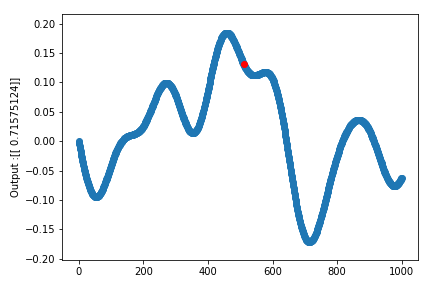

Output after iteration 1 is  0.02: 
Output after iteration 2 is  0.02: 
Output after iteration 3 is  0.02: 
Output after iteration 4 is  0.69: 
Output after iteration 5 is  0.02: 
Output after iteration 6 is  0.69: 
Output after iteration 7 is  0.02: 
Output after iteration 8 is  0.69: 
Output after iteration 9 is  0.02: 
Output after iteration 10 is  0.69: 
Output after iteration 12 is  0.02: 
Output after iteration 13 is  0.02: 
Output after iteration 14 is  0.02: 
Output after iteration 15 is  0.69: 
Output after iteration 16 is  0.02: 
Output after iteration 17 is  0.69: 
Output after iteration 18 is  0.02: 
Output after iteration 19 is  0.69: 
Output after iteration 20 is  0.02: 
Output after iteration 21 is  0.69: 
Output after iteration 23 is  0.03: 
Output after iteration 24 is  0.02: 
Output after iteration 25 is  0.02: 
Output after iteration 26 is  0.02: 
Output after iteration 27 is  0.02: 
Output after iteration 28 is  0.02: 
Output after iteration 29 is  0.02: 
Output aft

In [7]:

#Testing if the climber has learnt has learnt anything
climber.change_terrain(get_random_terrain())
climber_trainer(climber=climber,training=False,show_animation=True,reset_enabled=True,iterations=100)
% time

In [8]:
%matplotlib inline
x = np.arange(0,10000)
y = 52*x + np.random.normal(0,2500,x.shape)
x.shape

(10000,)

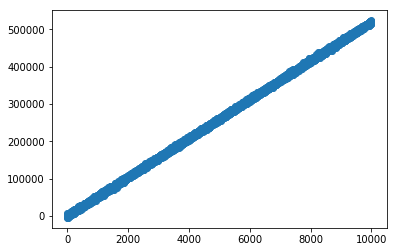

In [9]:
plt.scatter(x,y)

In [10]:
%%time
ws = linear_equation_solver(x,y,climber,0)

Correct weight is : 49.0
Wall time: 26 ms


In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
lr = LinearRegression(fit_intercept=False,normalize=True)

In [13]:
%%time
lr.fit(x.reshape(-1,1),y)
print(lr.coef_)

[ 51.99898496]
Wall time: 5 ms
